In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import glob2
import os
%matplotlib inline

# Calculate Perspective Transform Matix
(For later use)

In [2]:
standard_img = mpimg.imread('test3.jpg')
#img_size = (standard_img.shape[1], standard_img.shape[0])
src = np.float32(
    [[885, 559],
     [1049, 655],
     [310, 655],
     [450, 559]])

dst = np.float32(
    [[1049, 465],
     [1049, 655],
     [310, 655],
     [310, 485]])
M = cv2.getPerspectiveTransform(src, dst)

# Camera Calibration

In [3]:
objpoints = []
imgpoints = []
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
#images = glob2.glob('camera_cal/*.jpg')
images = os.listdir("camera_cal/")

for img in images:
    image = cv2.imread('camera_cal/' + img)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    #image_corners = cv2.drawChessboardCorners(image, (9,6), corners, ret)
    #cv2.imwrite('chessboard_corners/'+img, image_corners) 
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Undistorting and saving raw images

In [4]:
raw_images = os.listdir("test_images/")
for raw in raw_images:
    raw_image = cv2.imread('test_images/' + raw)
    undistorted = cv2.undistort(raw_image, mtx, dist, None, mtx)
    cv2.imwrite('test_images_undistorted/'+raw, undistorted)

# Reading a test image

In [5]:
image4 = mpimg.imread('test3.jpg')
#plt.imshow(image4)

# Defining various thresholds

In [6]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
    
    binary_output = np.zeros_like(dir_grad)
    binary_output[(dir_grad >= thresh[0]) & (dir_grad <= thresh[1])] = 1
    
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,sobel_kernel)
    sobelx_sqr = np.square(sobelx)
    sobely_sqr = np.square(sobely)
    abs_sobelxy = np.sqrt(sobelx_sqr+sobely_sqr)
    scaled_sobelxy = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    binary_output = np.zeros_like(scaled_sobelxy)
    binary_output[(scaled_sobelxy >= mag_thresh[0]) & (scaled_sobelxy <= mag_thresh[1])] = 1
    
    return binary_output

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,sobel_kernel)
        abs_sobelx = np.absolute(sobelx)
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    elif orient == 'y':
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,sobel_kernel)
        abs_sobely = np.absolute(sobely)
        scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
    else:
        print('Orientation not correct')
        scaled_sobel = np.zeros_like(img)
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sbinary

def hls_s(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary

def rgb_r(img, thresh=(0, 255)):
    R = img[:,:,2]
    binary_r = np.zeros_like(R)
    binary_r[(R > thresh[0]) & (R <= thresh[1])] = 1
    return binary_r

# Testing individual thresholds

Text(0.5, 1.0, 'dir_binary')

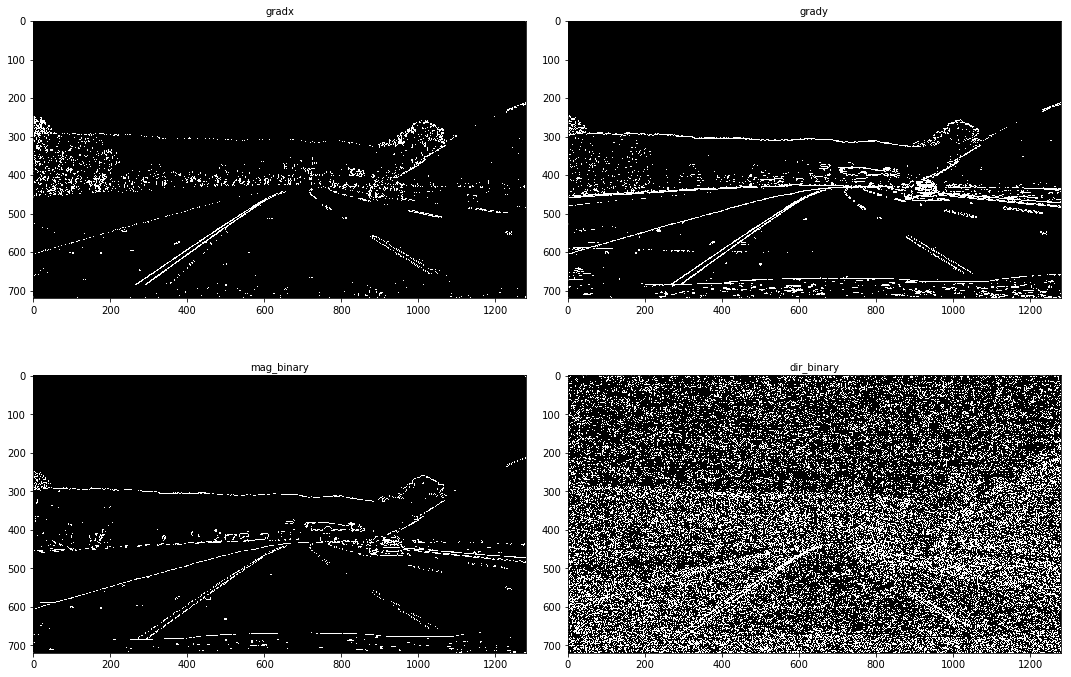

In [10]:
ksize = 3 
gradx = abs_sobel_thresh(image4, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image4, orient='y', sobel_kernel=ksize, thresh=(20, 170))
mag_binary = mag_thresh(image4, sobel_kernel=ksize, mag_thresh=(40, 100))
dir_binary = dir_threshold(image4, sobel_kernel=ksize, thresh=(0.9, 1.4))

f, axes = plt.subplots(2, 2, figsize=(15, 10))
f.tight_layout()
axes[0,0].imshow(gradx, cmap = 'gray')
axes[0,0].set_title('gradx', fontsize=10)
axes[0,1].imshow(grady, cmap = 'gray')
axes[0,1].set_title('grady', fontsize=10)
axes[1,0].imshow(mag_binary, cmap = 'gray')
axes[1,0].set_title('mag_binary', fontsize=10)
axes[1,1].imshow(dir_binary, cmap = 'gray')
axes[1,1].set_title('dir_binary', fontsize=10)

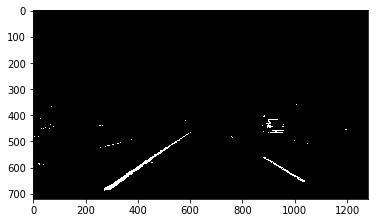

In [9]:
hls_binary = hls_s(image4, thresh=(130,255))
plt.imshow(hls_binary, cmap = 'gray')

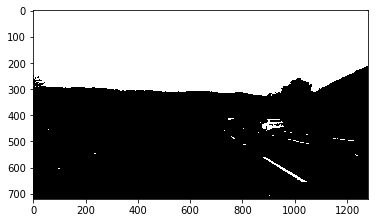

In [7]:
rgb_binary = rgb_r(image4, thresh=(170,255))
plt.imshow(rgb_binary, cmap = 'gray')

# Combining Thresholds

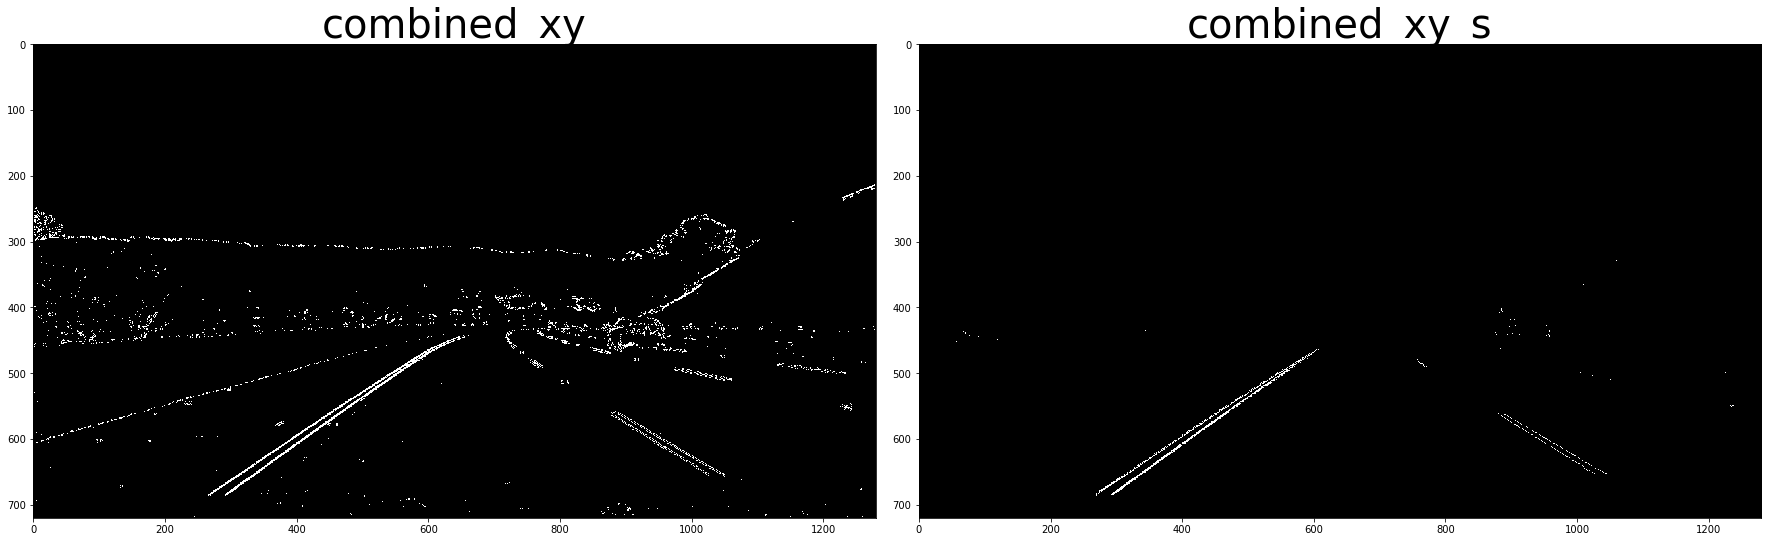

In [8]:
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image4, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image4, orient='y', sobel_kernel=ksize, thresh=(20, 170))
mag_binary = mag_thresh(image4, sobel_kernel=ksize, mag_thresh=(40, 100))
dir_binary = dir_threshold(image4, sobel_kernel=ksize, thresh=(0.7, 1.3))
hls_binary = hls_s(image4, thresh=(120,255))

combined = np.zeros_like(dir_binary)
combined_xy = np.zeros_like(dir_binary)
combined_mag_dir = np.zeros_like(dir_binary)
combined_xy_s = np.zeros_like(dir_binary)

combined_xy[((gradx == 1) & (grady == 1))] = 1
combined_mag_dir[((mag_binary == 1) & (dir_binary == 1))] = 1
combined_xy_s[(combined_xy ==1) & (hls_binary == 1)] = 1
#combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1


# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined_xy, cmap='gray')
ax1.set_title('combined_xy', fontsize=40)
ax2.imshow(combined_xy_s, cmap='gray')
ax2.set_title('combined_xy_s', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Perspective Transform

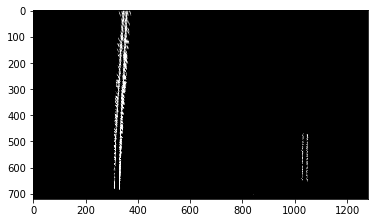

In [13]:
result_image = combined_xy_s
img_size = (result_image.shape[1], result_image.shape[0])
warped = cv2.warpPerspective(combined_xy_s, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(warped, cmap = 'gray')

# Fit First Polynomials

In [14]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 200
    # Set minimum number of pixels found to recenter window
    minpix = 60

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = np.zeros_like(nonzerox, dtype=bool)
    right_lane_inds = np.zeros_like(nonzerox, dtype=bool)

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - (margin//2)  
        win_xleft_high = leftx_current + (margin//2)
        win_xright_low = rightx_current - (margin//2) 
        win_xright_high = rightx_current + (margin//2) 
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### Done: Identify the nonzero pixels in x and y within the window ###
        boolYmin = (nonzeroy >= win_y_low)
        boolYmax = (nonzeroy <= win_y_high)
        booly = boolYmin & boolYmax
        
        boolXmin = (nonzerox >= win_xleft_low)
        boolXmax = (nonzerox <= win_xleft_high)
        boolx_left = boolXmin & boolXmax
        boolxy_left = booly & boolx_left
        good_left_inds = boolxy_left

        boolXmin = (nonzerox >= win_xright_low)
        boolXmax = (nonzerox <= win_xright_high)
        boolx_right = boolXmin & boolXmax
        boolxy_right = booly & boolx_right
        good_right_inds =boolxy_right

        # Append these indices to the lists
        left_lane_inds=left_lane_inds | good_left_inds
        right_lane_inds=right_lane_inds | good_right_inds
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        val_idxes_in_left_win =  nonzerox[good_left_inds]
        if(np.size(val_idxes_in_left_win) > minpix):
            leftx_current = sum(val_idxes_in_left_win)//np.size(val_idxes_in_left_win)
        val_idxes_in_right_win =  nonzerox[good_right_inds]
        if(np.size(val_idxes_in_right_win) > minpix):
            rightx_current = sum(val_idxes_in_right_win)//np.size(val_idxes_in_right_win)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds] #this is eqv. to boolxy_left for all windows
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds] #this is ---  boolxy_right ---
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [15]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,2)  
    right_fit = np.polyfit(righty,rightx,2)
    print (left_fit)
    print(right_fit)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 2.36880477e-05 -6.65360621e-02  3.53411207e+02]
[ 5.08725290e-05 -7.35912364e-02  1.06335504e+03]


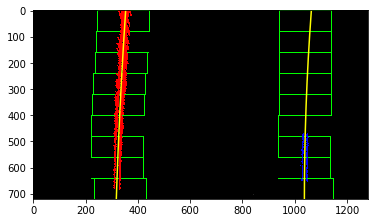

In [16]:
out_img = fit_polynomial(warped)
plt.imshow(out_img)

# Fit Subsequent Ploynomials

(Ignoring for now)

# Find Lanes Curvature

In [ ]:
def measure_curvature_real():
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit_cr, right_fit_cr = generate_data(ym_per_pix, xm_per_pix)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real()

print(left_curverad, 'm', right_curverad, 'm')
# Should see values of 533.75 and 648.16 here, if using
# the default `generate_data` function with given seed number